In [262]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


In [263]:
using Acceleration
using LinearAlgebra

n = 1000; # number of samples
d = 50;    # number of features
selected_labels = [0,1];  ## Only two labels allowed

data, labels = load_dataset("MNIST",[0,2],n,d);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);
μ2 = μ;



┌ Info: Loading dataset MNIST with 60000 samples and 784 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/datasets.jl:26


In [264]:
n = size(data,2)
x_ini = zeros(n)

using JuMP
using Ipopt

@time model = Model(with_optimizer(Ipopt.Optimizer))
@time set_silent(model)
@time @variable(model, x[1:n])
@time @objective(model, Min, f(x))
@time optimize!(model)
@time x_opt = value.(x);

  0.000183 seconds (652 allocations: 36.172 KiB)
  0.000003 seconds
  0.032060 seconds (63.86 k allocations: 3.311 MiB)
  0.091252 seconds (22.77 k allocations: 52.967 MiB)
  0.004937 seconds (911 allocations: 173.641 KiB)
  0.000052 seconds (603 allocations: 12.234 KiB)


In [265]:
n = length(x_ini)
x = x_ini;
y = zeros(n);
z = zeros(n);
v = zeros(n);
A0 = σ/(2*L);
A = A0;
AX = zeros(n);

k = 1000;
yks = zeros(n,k);
var_ξ = zeros(k)
#μ = 0;
s = zeros(n);
noise = 0;
p = 1

for i=1:k   
    p = 5
    λ = min((L/μ)*(p/i)^2, 1)
    #λ = min((p+1)*(i+1)^(p-1),1)
    a = L-μ; b = -λ*(μ*A + σ); c = -λ*(μ*A^2 + σ*A);
    α = (-b + sqrt(b^2 - 4*a*c)) / (2*a);
    A = A + α;
    x = (A-α)/A*y + α/A*v; 
    AX = AX + α*x;

    η = zeros(n)
    approx_gradient = ∇f(x)+η;
    
    s = s + α*η;
    z = z - α*approx_gradient;
    
    v_past = v;
    v = (z + μ*AX)*inv(1 + μ*(A-A0));
    y = (A-α)*inv(A)*y + α*inv(A)*v; 
    var_ξ[i] = sqrt(1-λ)*(μ*(A-α) + σ)/α * norm(v - v_past,2);
    
    #println(var_ξ)
    
    yks[:,i] = y;
        
end

x_out = yks;
x_gd = gradient_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd = accelerated_mirror_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd2 = SCVX_AMD(f,∇f,∇ϕ_cjg,x_ini,σ,L,μ2,k);

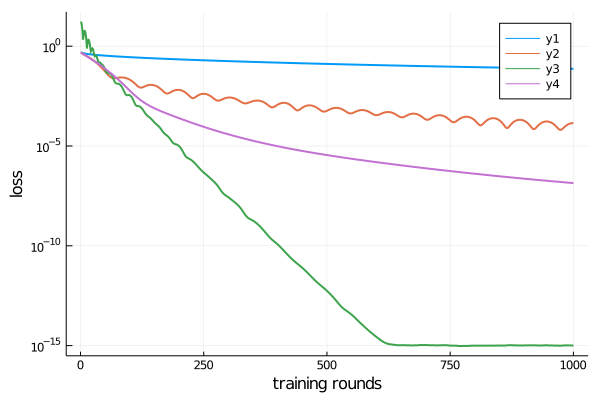

In [261]:
using Plots
using LinearAlgebra

p_out = sqrt.(sum((x_out .- x_opt).^2, dims=1)');
p_gd = sqrt.(sum((x_gd .- x_opt).^2, dims=1)');
p_amd = sqrt.(sum((x_amd .- x_opt).^2, dims=1)');
p_amd2 = sqrt.(sum((x_amd2 .- x_opt).^2, dims=1)');

plot(max.(hcat(p_gd,p_amd,p_amd2,p_out),1e-20),yaxis=:log,linewidth=2,xlabel="training rounds",ylabel="loss")
#plot(max.(hcat(p_out),1e-20),yaxis=:log)

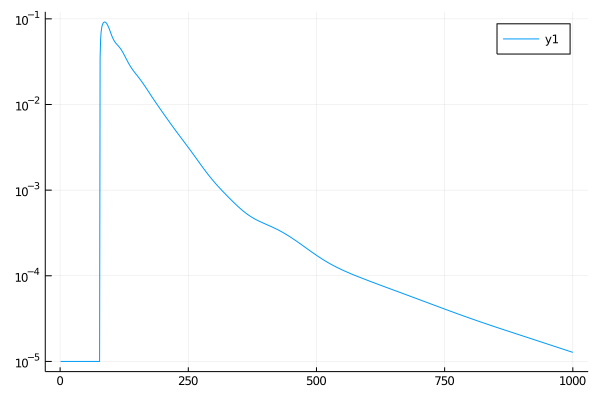

In [259]:
plot(max.(var_ξ,1e-5),yaxis=:log)

In [233]:
p

0.3150187641011394